# Proyecto final - Estrategias Comerciales con Datos

## Rodrigo González, Juan Ignacio Briozzo, Ignacio González  y Belén Puga

## Segundo semestre 2023

In [1]:
!pip install -q eccd_datasets pygradus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 23.9 MB/s eta 0:00:00


In [2]:
# Download the original lables used when training a resnet

import json
!wget https://files.fast.ai/models/imagenet_class_index.json -O resnet_labels.json
with open("resnet_labels.json", "r") as fh: data = json.load(fh)
resnet_labels = {}
for k, v in data.items():
    resnet_labels[int(k)] = v[1]

--2023-12-02 20:15:54--  https://files.fast.ai/models/imagenet_class_index.json
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 104.26.2.19, 172.67.69.159, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘resnet_labels.json’

resnet_labels.json  100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2023-12-02 20:15:55 (3.10 MB/s) - ‘resnet_labels.json’ saved [35363/35363]



In [3]:
import io
import torch
import pandas as pd
import torchvision.transforms as transf
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models
from pathlib import Path
from PIL import Image
from eccd_datasets import load_images

from pygradus import create_exercise, check_solution

torch.manual_seed(42)

from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

## Exploramos el dataset

In [4]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [5]:
##loss function:

def calculate_cost(X, Y):
    if X >= Y:
        return abs(5 * (X - Y))
    else:
        return abs(Y - X)

In [6]:
calculate_cost(1,1)

0

In [7]:
##item prices:

item_prices = {
    'Apple': 74,
    'Pear': 89,
    'Satsumas': 44,
    'Melon': 109,
    'Orange': 35
}

In [8]:
# Mapeamos los precios por producto en base al diciconario generado
df_images['prices'] = df_images['coarse_cat'].map(item_prices)

In [9]:
# Verificamos que los precios hayan quedado bien asignados
df_images.groupby("coarse_cat").mean()

<ipython-input-9-7cafa3506e95>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_images.groupby("coarse_cat").mean()


,prices
coarse_cat,
Apple,74.0
Melon,109.0
Orange,35.0
Pear,89.0
Satsumas,44.0


# Separamos el dataset en train, test y validation

In [10]:
# Separamos subsets de los datos para usar en test, train y alidación
df_train = df_images[df_images["dataset"]=="train"]
df_test = df_images[df_images["dataset"]=="test"]
df_val = df_images[df_images["dataset"]=="val"]

## Verificamos que las clases esten correctamente representadas en train, test y validation

In [11]:
df_train.groupby(df_train["coarse_cat"]).sum()


<ipython-input-11-0dba6c5e10ba>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train.groupby(df_train["coarse_cat"]).sum()


,prices
coarse_cat,
Apple,20572
Melon,16786
Orange,1995
Pear,10324
Satsumas,3080


In [12]:
df_images.groupby(df_images["coarse_cat"]).sum()


<ipython-input-12-ec7de93460ce>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_images.groupby(df_images["coarse_cat"]).sum()


,prices
coarse_cat,
Apple,63048
Melon,52320
Orange,6090
Pear,29993
Satsumas,9284


In [13]:
df_val.groupby(df_val["coarse_cat"]).sum()


<ipython-input-13-d60da68557d4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_val.groupby(df_val["coarse_cat"]).sum()


,prices
coarse_cat,
Apple,1628
Melon,2180
Orange,175
Pear,445
Satsumas,220


In [14]:
df_test.groupby(df_test["coarse_cat"]).sum()


<ipython-input-14-0392f34a7903>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test.groupby(df_test["coarse_cat"]).sum()


,prices
coarse_cat,
Apple,40848
Melon,33354
Orange,3920
Pear,19224
Satsumas,5984


# Aplicamos transformacioes a train y generamos un nuevo dataset considerando las imágenes transformadas

In [15]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

In [16]:
def center_crop_transformation(image, size: int) -> np.array:
    """
    This function uses a pytorch transformation to
    center and crop the image
    """


    # Center-crop transformation
    center_crop = transf.CenterCrop(size)

    # Aplicamos la transformación center-crop
    cropped_image_pil = center_crop(image)

    # Reconvertimos la imagen cortada a un array
    cropped_image_np = np.array(cropped_image_pil)

    return cropped_image_np


In [17]:
imagenes_train = [load_image_data(df_train.iloc[i]["image_data"]) for i in range(len(df_train))]

crop_train = [center_crop_transformation(image, 150) for image in imagenes_train]

pil_crop_train = [Image.fromarray(np.uint8(image)) for image in crop_train]

In [18]:
df_crop_train = df_train.copy()

df_crop_train["image_data"] = pil_crop_train

## Random Horizontal Flip transformation

In [19]:
transformation_hf = transf.RandomHorizontalFlip()

maybe_flipped = [transformation_hf.forward(image) for image in imagenes_train]

In [20]:
pil_hf_train = [Image.fromarray(np.uint8(image)) for image in maybe_flipped]

In [21]:
df_hf_train = df_train.copy()

df_hf_train["image_data"] = pil_hf_train

## Aplicamos Rotación

In [22]:
transformation_rot = transf.RandomRotation(15)  # Rotación aleatoria de hasta 15 grados

transf_df_train = [transformation_rot.forward(image) for image in imagenes_train]

In [23]:
transf_train = [Image.fromarray(np.uint8(image)) for image in transf_df_train]

In [24]:
transf_df_train = df_train.copy()

In [25]:
transf_df_train["image_data"] = transf_train

## Variación aleatoria del color

In [26]:
transformation_color = transf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)  # Ajuste aleatorio del color

color_df_train = [transformation_color.forward(image) for image in imagenes_train]

In [27]:
color_train = [Image.fromarray(np.uint8(image)) for image in color_df_train]

In [28]:
color_df_train = df_train.copy()

In [29]:
color_df_train["image_data"] = color_train

# Aplicamos transformaciones adicionales a las mandarinas y naranjas

In [30]:
# Dado que la mayoría de los errores se deben a las mandarinas y naranjas vamos a aplicar transformaciones adicionales a estas para ayudar a identificarlas
transf_color_zoom_rotate = transf.Compose([
    transf.ColorJitter(brightness=0.25, contrast=0.3, saturation=0.2, hue=0.1),
    transf.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0),
    transf.RandomRotation(degrees=(-10, 10)),  # Rango de rotación aleatoria
])

df_mandarinas_train = df_train[df_train["coarse_cat"]=="Satsumas"]

imagenes_train2 = [load_image_data(df_mandarinas_train.iloc[i]["image_data"]) for i in range(len(df_mandarinas_train))]


mandarinas_transf = [transf_color_zoom_rotate(image) for image in imagenes_train2]


In [31]:
df_mandarinas_train["image_data"] = mandarinas_transf

<ipython-input-31-d82bf3656ead>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mandarinas_train["image_data"] = mandarinas_transf


In [32]:
df_mandarinas_train.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
798,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=348x348 a...,44
799,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=348x348 a...,44
800,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=348x348 a...,44
801,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=348x348 a...,44
802,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=348x348 a...,44


# Mergeamos los datasets con la imágenes aplicadas las transformaciones

In [33]:
images_train = [load_image_data(row["image_data"]) for _, row in df_train.iterrows()]

In [34]:
df_train2 = df_train.copy()

In [35]:
df_train2["image_data"] = images_train

In [36]:
# datasets: df_train2
#           df_crop_train
#           df_hf_train
#           transf_df_train
#           color_df_train
#           df_mandarinas_train


dataframes = [df_train2, df_crop_train, df_hf_train, transf_df_train, color_df_train, df_mandarinas_train]
#dataframes = [df_train2, df_crop_train, df_hf_train, transf_df_train]

result_df_train = pd.concat(dataframes, ignore_index=True)

In [37]:
result_df_train.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
0,train,Apple,Golden-Delicious,<PIL.JpegImagePlugin.JpegImageFile image mode=...,74
1,train,Apple,Golden-Delicious,<PIL.JpegImagePlugin.JpegImageFile image mode=...,74
2,train,Apple,Golden-Delicious,<PIL.JpegImagePlugin.JpegImageFile image mode=...,74
3,train,Apple,Golden-Delicious,<PIL.JpegImagePlugin.JpegImageFile image mode=...,74
4,train,Apple,Golden-Delicious,<PIL.JpegImagePlugin.JpegImageFile image mode=...,74


In [38]:
# Dado que la mayoría de los errores se deben a las mandarinas y naranjas vamos a aplicar transformaciones adicionales a estas para ayudar a identificarlas
transf_color_zoom_rotate2 = transf.Compose([
    transf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.2),
    transf.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0),
    transf.RandomRotation(degrees=(-5, 5)),
    transf.RandomHorizontalFlip(p=0.3)  # p=0.5 indica que el volteo es aleatorio con probabilidad 50%
])


imagenes_train3 = [result_df_train.iloc[i]["image_data"] for i in range(len(result_df_train))]

result_df_train_transf = [transf_color_zoom_rotate2(image) for image in imagenes_train3]

In [39]:
result_df_train_transf

[<PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x464>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=348x348>,
 <PIL.Image.Image image mode=RGB size=34

In [40]:
result_df_train["image_data"] = result_df_train_transf

## Aplicamos un Resize a las imágenes

In [41]:
images = [i for i in result_df_train["image_data"]]

In [42]:
images_array = np.array([np.array(img) for img in images])

<ipython-input-42-219c93988b9d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images_array = np.array([np.array(img) for img in images])


In [43]:
resize = transf.Compose([
    # Resize
    transf.Resize((224, 224))
])

In [44]:
# Aplicamos las transformaciones a las imágenes
resized_images = []
for image in images:
    transformed_image = resize(image)
    resized_images.append(transformed_image)

In [45]:
result_df_train2 = result_df_train.copy()

In [46]:
result_df_train2.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
0,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74
1,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74
2,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74
3,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74
4,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74


In [47]:
# Creamos una nueva base con la columna de las imágenes hecha aplicando el resize
result_df_train2["image_data"] = resized_images

## Calculamos la media de los tres canales (RGB) para hacer la normalización

In [48]:
# Pasamos las imágenes a arrays para hacer los cálculos
array_imagenes = np.array([np.array(im) for im in resized_images], dtype=object)

In [49]:
array_imagenes.shape

(3445, 224, 224, 3)

In [50]:
array_imagenes = array_imagenes.astype(float)

In [51]:
mean_train_total = np.mean(array_imagenes, axis=(0, 1, 2))

In [52]:
sd_train_total = np.std(array_imagenes, axis=(0, 1, 2))

In [53]:
print(mean_train_total, sd_train_total)

[112.48956887  84.8498463   49.012155  ] [73.27559039 70.30319732 49.18781919]


## Normalización

In [54]:
normalization = transf.Compose([
        transf.ToTensor(),
        transf.Normalize(
            mean_train_total,
            sd_train_total,
            )
    ])

In [55]:
# Aplicamos la normalización

#norm_images = [normalization(img) for img in resized_images]

In [56]:
result_df_train2.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
0,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74
1,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74
2,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74
3,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74
4,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74


In [57]:
len(result_df_train2["image_data"])

3445

In [58]:
'''
Hasta ahora contamos con lo siguiente para el modelo:

- Train:

Usamos el dataset result_df_train2 que tiene las imágenes orginales
y las transformadas mediante crop, traslación, rotación, etc, y aplicado el resize a 150x150 pixeles cada imagen

El dataset de train al sumar todas las transformaciones y las imágenes originales quedó con 3375 imágenes


- Validation: usamos df_val

- Test: usamos df_test


'''

'\nHasta ahora contamos con lo siguiente para el modelo:\n\n- Train:\n\nUsamos el dataset result_df_train2 que tiene las imágenes orginales\ny las transformadas mediante crop, traslación, rotación, etc, y aplicado el resize a 150x150 pixeles cada imagen\n\nEl dataset de train al sumar todas las transformaciones y las imágenes originales quedó con 3375 imágenes\n\n\n- Validation: usamos df_val\n\n- Test: usamos df_test\n\n\n'

# Modelo a partir de Transfer Learning usando Resnet18

In [59]:
# Definimos la GPU para seleccionarlo como el device de torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [60]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


In [61]:
#resnet

In [62]:
# Eliminamos la última capa al modelo origial
model_aux = nn.Sequential(*list(resnet.children())[:-1])

In [63]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = True # incicamos que el atributo que indica que los parámetros son entrenables sea falso para todos estos de modo que no se entrenen en el posterior período de train (se puede hacer pero es computacionalmente costoso)

In [64]:
hidden1 = 256
hidden = 256
lr = 0.001
epochs = 5
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))


# Mdoelo:
#         1) Como primera capa se pasa el modelo auxiliar de ResNet18 sin la última capa
model1 = nn.Sequential(model_aux,
                       nn.Flatten(), # le aplicamos un flatten a la red resultante de model_aux para poder aplicarle capas densas para el entrenamiento específico de nuestro modelo
                       nn.Linear(in_features=512, out_features= 5, bias= True)) # esto es lo que hay que modificar, hay que poner capas densas para poder terminar en una ¿softmax? para poder clasificar dentro de los 4 tipos de frutas que tenemos
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [65]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [66]:
df_train

,dataset,coarse_cat,finegrained_cat,image_data,prices
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
...,...,...,...,...,...
1100,train,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,35
1101,train,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,35
1102,train,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,35
1103,train,Orange,Orange,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,35


In [67]:
# Hacemos un encoder a las etiquetas para que el modelo las pueda entender
labels = result_df_train2['coarse_cat'].unique()

In [68]:
label_encoder = LabelEncoder()

In [69]:
label_encoder.fit(labels)

LabelEncoder()

In [70]:
result_df_train2['encoded_labels'] = label_encoder.transform(result_df_train2['coarse_cat'])

In [71]:
result_df_train2["encoded_labels"].head() # ver posibilidad de hacer un encode en código binario

0    0
1    0
2    0
3    0
4    0
Name: encoded_labels, dtype: int64

In [72]:
result_df_train2

,dataset,coarse_cat,finegrained_cat,image_data,prices,encoded_labels
0,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0
1,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0
2,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0
3,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0
4,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0
...,...,...,...,...,...,...
3440,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=224x224 a...,44,4
3441,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=224x224 a...,44,4
3442,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=224x224 a...,44,4
3443,train,Satsumas,Satsumas,<PIL.Image.Image image mode=RGB size=224x224 a...,44,4


In [73]:
df_val['encoded_labels'] = label_encoder.transform(df_val['coarse_cat'])

<ipython-input-73-dd938eeb4b4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['encoded_labels'] = label_encoder.transform(df_val['coarse_cat'])


In [74]:
# Aplicamos la codificación one-hot a la columna 'coarse_cat'
one_hot = pd.get_dummies(result_df_train2['coarse_cat'])

# Unimos el dataframe one_hot con nuestro dataframe original
result_df_train2 = result_df_train2.join(one_hot)

# Mostramos las primeras filas del dataframe
result_df_train2.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices,encoded_labels,Apple,Melon,Orange,Pear,Satsumas
0,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0,1,0,0,0,0
1,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0,1,0,0,0,0
2,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0,1,0,0,0,0
3,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0,1,0,0,0,0
4,train,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=224x224 a...,74,0,1,0,0,0,0


In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))


In [76]:
'''
for epoch in range(epochs):
    model1.train()

    for images, labels in train_loader:  # Asegúrate de tener el DataLoader correctamente configurado
        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    #acc = accuracy(model1, val_loader)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
'''

"\nfor epoch in range(epochs):\n    model1.train()\n\n    for images, labels in train_loader:  # Asegúrate de tener el DataLoader correctamente configurado\n        optimizer.zero_grad()\n\n        outputs = model1(images)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n    #acc = accuracy(model1, val_loader)\n\n    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')\n"

## Probamos otra manera

In [77]:
# Definimos las transformaciones para entrenamiento y validación
train_transform = transf.Compose([
        transf.ToTensor(),
        transf.Normalize(
            mean_train_total,
            sd_train_total,
            )
    ])

val_transform = transf.Compose([
    transf.ToTensor()

])


In [78]:
df_val.head() #hay que pasar image_dat a fomrato pil

,dataset,coarse_cat,finegrained_cat,image_data,prices,encoded_labels
3376,val,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74,0
3377,val,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74,0
3378,val,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74,0
3379,val,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74,0
3380,val,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74,0


In [79]:
imagenes_val = [load_image_data(df_val.iloc[i]["image_data"]) for i in range(len(df_val))]

In [80]:
array_imagenes_val = np.array([np.array(img) for img in imagenes_val])

In [81]:
pil_val = [Image.fromarray(np.uint8(image)) for image in array_imagenes_val]

In [82]:
df_val["image_data"] = pil_val

<ipython-input-82-1dfa494f3d1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["image_data"] = pil_val


In [83]:
df_val.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices,encoded_labels
3376,val,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74,0
3377,val,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74,0
3378,val,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74,0
3379,val,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74,0
3380,val,Apple,Golden-Delicious,<PIL.Image.Image image mode=RGB size=348x348 a...,74,0


In [84]:
#train_loader

In [85]:
# Vamos de nuevo con las labels hecho el encode

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Obtener la imagen (asegúrate de tener las imágenes preprocesadas como tensores)
        image = self.dataframe.iloc[idx]['image_data']

        # Obtener la etiqueta (asegúrate de tener las etiquetas codificadas)
        label = self.dataframe.iloc[idx]['encoded_labels']

        # Aplicar transformaciones, si las tienes
        if self.transform:
            image = self.transform(image)

        return image, label

In [86]:
# Creamos instancias de CustomDataset para entrenamiento y validación
train_dataset = CustomDataset(result_df_train2, transform=train_transform)
val_dataset = CustomDataset(df_val, transform=val_transform)


# Crea DataLoader para entrenamiento y validación
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [87]:
normalization_train = transf.Compose([
        transf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transf.ToTensor(),
        transf.Normalize(
            mean_train_total,
            sd_train_total,
            )
    ])

In [88]:
dataset_train = CustomDataset(dataframe=result_df_train2, transform=normalization)

In [89]:
batch_size = 32  # Puedes ajustar este valor según tus necesidades
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

In [90]:
transform = transf.Compose([
    transf.Resize((224, 224)),
    transf.ToTensor(),
])

In [91]:
df_val_custom = CustomDataset(dataframe=df_val, transform=normalization)

In [92]:
val_loader = DataLoader(df_val_custom, batch_size=batch_size, shuffle=False)

Eliminamos la última capa del modelo para poder ajustarlo a nuestro caso

In [93]:
resnet_ajustado = nn.Sequential(*list(resnet.children())[:-1])

In [94]:
for i, parameter in enumerate(resnet_ajustado.parameters()):
    parameter.requires_grad = False # incicamos que el atributo que indica que los parámetros son entrenables sea falso para todos estos de modo que no se entrenen en el posterior período de train (se puede hacer pero es computacionalmente costoso)

In [95]:
#for i, parameter in enumerate(resnet_ajustado.parameters()):
#   print(i, parameter.requires_grad) # Verificamos que los parámetroos de esta red se pusieron todos como falsos

# Entrenamiento del modelo

In [96]:
#for images,labels in train_loader:
 # print(images,labels)

In [97]:
train_loader

In [98]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total


# Loop de entrenamiento

In [99]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [100]:
hidden1 = 256
hidden = 128
lr = 0.00001
epochs = 30
model1 = nn.Sequential(
    model_aux,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=hidden1),
    nn.BatchNorm1d(hidden1),  # Capa de Batch Normalization
    nn.ReLU(),
    nn.Dropout(p=0.1),  # Capa de Dropout con probabilidad de 0.1
    nn.Linear(in_features=hidden1, out_features=hidden),
    nn.BatchNorm1d(hidden),  # Capa de Batch Normalization
    nn.ReLU(),
    nn.Dropout(p=0.1),  # Capa de Dropout con probabilidad de 0.1
    nn.Linear(in_features=hidden, out_features=5))


# Mdoelo:
#         1) Como primera capa se pasa el modelo auxiliar de ResNet18 sin la última capa
#model1 = nn.Sequential(model_aux,
#                       nn.Flatten(), # le aplicamos un flatten a la red resultante de model_aux para poder aplicarle capas densas para el entrenamiento específico de nuestro modelo
#                       nn.Linear(in_features=512, out_features= 5, bias= True)) # esto es lo que hay que modificar, hay que poner capas densas para poder terminar en una ¿softmax? para poder clasificar dentro de los 4 tipos de frutas que tenemos
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))


In [101]:
#train(model1, optimiser, 20)

In [102]:
df_test2 = df_test.copy()

df_test2['encoded_labels'] = label_encoder.transform(df_test2['coarse_cat'])

test_transform = transf.Compose([
    transf.Resize((224, 224)),
    transf.ToTensor(),
    transf.Normalize(mean=mean_train_total, std=sd_train_total)
])

imagenes_test = [load_image_data(df_test2.iloc[i]["image_data"]) for i in range(len(df_test2))]
array_imagenes_test = np.array([np.array(img) for img in imagenes_test])
pil_test = [Image.fromarray(np.uint8(image)) for image in array_imagenes_test]
df_test2["image_data"] = pil_test

# Cargar datos de prueba
df_test_custom = CustomDataset(dataframe=df_test2, transform=test_transform)
test_loader = DataLoader(df_test_custom, batch_size=batch_size, shuffle=False)

# Evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader):
    model.eval()
    model.to(device)
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

<ipython-input-102-7b744d2e0137>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_imagenes_test = np.array([np.array(img) for img in imagenes_test])


In [103]:
import torch.optim as optim
from torchvision import datasets, models, transforms


# Adjusted Model
class CustomResNetModel(nn.Module):
    def __init__(self, pretrained_model, num_classes=5):
        super(CustomResNetModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.pretrained_model.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 5000), #ResNet50 tiene 2048 neuronas de salida, ResNet18 tiene 512
            nn.BatchNorm1d(5000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(5000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, num_classes)
        )

    def forward(self, x):
        features = self.pretrained_model(x)
        return self.classifier(features)

# Iniciamos el mdodelo
resnet = models.resnet50(pretrained=True)
model = CustomResNetModel(resnet, num_classes=5)

# Optimizador y Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Función de entrenamiento
def train(model, optimizer, scheduler, train_loader, val_loader, epochs=30):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Ajusta el learning rate para ayudar a escapar de mínimos locales
        scheduler.step()

        # Evaluación
        model.eval()
        with torch.no_grad():
            train_accuracy = accuracy(model, train_loader)
            val_accuracy = accuracy(model, val_loader)
            test_accuracy = accuracy(model, test_loader)

            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy},Test accuracy: {test_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [104]:
# Train the model
#train(model, optimizer, scheduler, train_loader, val_loader, epochs=10)

In [105]:
torch.save(model1.state_dict(), 'modelo_entrenado.pth')

In [106]:
df_test.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
1142,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1143,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1144,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1145,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1146,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74


In [107]:
from sklearn.metrics import accuracy_score


In [108]:
# Evaluar el modelo en el conjunto de prueba
test_accuracy = evaluate_model(model, test_loader)

print(f'Accuracy on test set: {test_accuracy:.4f}')

Accuracy on test set: 0.1029


# Verificamos las predicciones

In [109]:
df_test.head()

,dataset,coarse_cat,finegrained_cat,image_data,prices
1142,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1143,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1144,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1145,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74
1146,test,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,74


In [110]:
from tqdm import tqdm

In [111]:
# Establecer el modelo en modo de evaluación
model.eval()

# Lista para almacenar las etiquetas reales y predichas
true_labels = []
predicted_labels = []

# Realizar predicciones en el conjunto de prueba
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convertir las etiquetas a numpy arrays para facilitar la comparación
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Testing: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]


In [112]:
#true_labels

In [113]:
#predicted_labels

In [114]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

In [115]:
result_df_train2.groupby("coarse_cat").mean()

<ipython-input-115-8fb819e8b19a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_train2.groupby("coarse_cat").mean()


,prices,encoded_labels,Apple,Melon,Orange,Pear,Satsumas
coarse_cat,,,,,,,
Apple,74.0,0.0,1.0,0.0,0.0,0.0,0.0
Melon,109.0,1.0,0.0,1.0,0.0,0.0,0.0
Orange,35.0,2.0,0.0,0.0,1.0,0.0,0.0
Pear,89.0,3.0,0.0,0.0,0.0,1.0,0.0
Satsumas,44.0,4.0,0.0,0.0,0.0,0.0,1.0


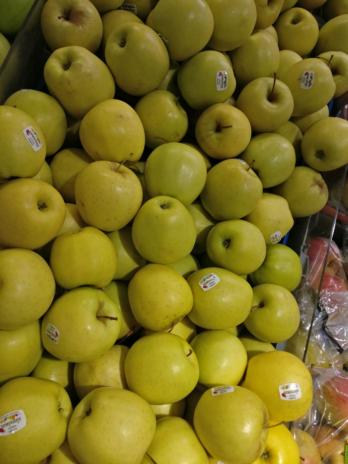

In [116]:
load_image_data(df_test["image_data"].iloc[1])

In [117]:
result_df_train2.groupby("coarse_cat").count()

,dataset,finegrained_cat,image_data,prices,encoded_labels,Apple,Melon,Orange,Pear,Satsumas
coarse_cat,,,,,,,,,,
Apple,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390
Melon,770,770,770,770,770,770,770,770,770,770
Orange,285,285,285,285,285,285,285,285,285,285
Pear,580,580,580,580,580,580,580,580,580,580
Satsumas,420,420,420,420,420,420,420,420,420,420


In [118]:
df_resultados = pd.DataFrame({'True Labels': true_labels, 'Predicted Labels': predicted_labels})

In [119]:
df_resultados

,True Labels,Predicted Labels
0,0,4
1,0,4
2,0,4
3,0,4
4,0,4
...,...,...
1317,2,4
1318,2,4
1319,2,4
1320,2,4


In [120]:
df_resultados['Correct Prediction'] = (df_resultados['True Labels'] == df_resultados['Predicted Labels']).astype(int)

In [121]:
df_resultados

,True Labels,Predicted Labels,Correct Prediction
0,0,4,0
1,0,4,0
2,0,4,0
3,0,4,0
4,0,4,0
...,...,...,...
1317,2,4,0
1318,2,4,0
1319,2,4,0
1320,2,4,0


In [122]:
df_resultados['Correct Prediction'].sum()

136

In [123]:
df_resultados[df_resultados["True Labels"] == 1]['Correct Prediction'].sum()

0

In [124]:
df_resultados[df_resultados["True Labels"] == 1]

,True Labels,Predicted Labels,Correct Prediction
452,1,4,0
453,1,4,0
454,1,4,0
455,1,4,0
456,1,4,0
...,...,...,...
1261,1,4,0
1262,1,4,0
1263,1,4,0
1264,1,4,0


In [125]:
272/306

0.8888888888888888

In [126]:
df_resultados[df_resultados["True Labels"] == 2]['Correct Prediction'].sum()

0

In [127]:
df_resultados[df_resultados["True Labels"] == 2]

,True Labels,Predicted Labels,Correct Prediction
605,2,4,0
606,2,4,0
607,2,4,0
608,2,4,0
609,2,4,0
...,...,...,...
1317,2,4,0
1318,2,4,0
1319,2,4,0
1320,2,4,0


In [128]:
df_resultados[df_resultados["True Labels"] == 4]['Correct Prediction'].sum()

136

In [129]:
df_resultados[df_resultados["True Labels"] == 4]

,True Labels,Predicted Labels,Correct Prediction
384,4,4,1
385,4,4,1
386,4,4,1
387,4,4,1
388,4,4,1
...,...,...,...
1108,4,4,1
1109,4,4,1
1110,4,4,1
1111,4,4,1


In [130]:
df_resultados[df_resultados["True Labels"] == 0]['Correct Prediction'].sum()

0

In [131]:
df_resultados[df_resultados["True Labels"] == 0]

,True Labels,Predicted Labels,Correct Prediction
0,0,4,0
1,0,4,0
2,0,4,0
3,0,4,0
4,0,4,0
...,...,...,...
932,0,4,0
933,0,4,0
934,0,4,0
935,0,4,0


In [132]:
df_resultados[df_resultados["True Labels"] == 3]['Correct Prediction'].sum()

0

In [133]:
df_resultados[df_resultados["True Labels"] == 3]

,True Labels,Predicted Labels,Correct Prediction
276,3,4,0
277,3,4,0
278,3,4,0
279,3,4,0
280,3,4,0
...,...,...,...
1040,3,4,0
1041,3,4,0
1042,3,4,0
1043,3,4,0


In [134]:
def asignar_precio(label):
    if label == 0:
        return 74
    elif label == 1:
        return 109
    elif label == 2:
        return 35
    elif label == 3:
        return 89
    elif label == 4:
        return 44
    else:
        return None

In [135]:
df_resultados['Precio_Verdadero'] = df_resultados['True Labels'].apply(asignar_precio)
df_resultados['Precio_predicho'] = df_resultados['Predicted Labels'].apply(asignar_precio)

In [136]:
df_resultados['Costo unitario'] = df_resultados.apply(lambda row: calculate_cost(row['Precio_predicho'], row['Precio_Verdadero']), axis=1)
df_resultados.head()

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,Costo unitario
0,0,4,0,74,44,30
1,0,4,0,74,44,30
2,0,4,0,74,44,30
3,0,4,0,74,44,30
4,0,4,0,74,44,30


In [137]:
print ("El costo total asociado a la asignación automática de productos es", df_resultados["Costo unitario"].sum())

El costo total asociado a la asignación automática de productos es 51210


In [144]:
import torch.optim as optim
from torchvision import datasets, models, transforms


# Adjusted Model
class CustomResNetModel(nn.Module):
    def __init__(self, pretrained_model, num_classes=5):
        super(CustomResNetModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.pretrained_model.fc = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 5000), #ResNet50 tiene 2048 neuronas de salida, ResNet18 tiene 512
            nn.BatchNorm1d(5000),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(5000, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, num_classes)

        )

    def forward(self, x):
        features = self.pretrained_model(x)
        return self.classifier(features)

# Iniciamos el mdodelo
resnet = models.resnet50(pretrained=True)
model = CustomResNetModel(resnet, num_classes=5)

# Optimizador y Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


In [145]:
def calculate_validation_loss(model, criterion, val_loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    average_loss = total_loss / len(val_loader)
    return average_loss


In [146]:
test_acc = []
val_acc = []
train_acc = []
costo_total_lista = []
costo_prom_lista = []

In [311]:
# Función de entrenamiento
def train(model, optimizer, scheduler, train_loader, val_loader, epochs=30):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = calculate_validation_loss(model, criterion, val_loader, device)

        # Ajusta el learning rate para ayudar a escapar de mínimos locales
        scheduler.step(val_loss)

        # Establecer el modelo en modo de evaluación
        model.eval()

        # Lista para almacenar las etiquetas reales y predichas
        true_labels = []
        predicted_labels = []

        # Realizar predicciones en el conjunto de prueba
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())



        # Convertir las etiquetas a numpy arrays para facilitar la comparación
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        df_resultados = pd.DataFrame({'True Labels': true_labels, 'Predicted Labels': predicted_labels})

        df_resultados['Precio_Verdadero'] = df_resultados['True Labels'].apply(asignar_precio)
        df_resultados['Precio_predicho'] = df_resultados['Predicted Labels'].apply(asignar_precio)

        costo_unitario = [calculate_cost(df_resultados['Precio_predicho'][i],df_resultados['Precio_Verdadero'][i]) for i in range(len(df_resultados))]
        costo_total = sum(costo_unitario)
        costo_promedio = costo_total/len(df_resultados)



        # Evaluación
        model.eval()
        with torch.no_grad():
            train_accuracy = accuracy(model, train_loader)
            val_accuracy = accuracy(model, val_loader)
            test_accuracy = accuracy(model, test_loader)
            test_acc.append(test_accuracy)
            val_acc.append(val_accuracy)
            train_acc.append(train_accuracy)
            costo_total_lista.append(costo_total)
            costo_prom_lista.append(costo_promedio)

            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy},Test accuracy: {test_accuracy:.4f}, costo en test:{costo_total}, costo promedio:{costo_promedio}')


# Ver de usar la pérdida en validación y no solo en test (o de usar para algo el conjunto de validación)

In [149]:
sum([calculate_cost(df_resultados['Precio_Verdadero'][i],df_resultados['Precio_predicho'][i]) for i in range(len(df_resultados))])

231858

In [150]:
train(model, optimizer, scheduler, train_loader, val_loader, epochs=30)

Testing: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch: 1, Loss: 0.5696161389350891, Train Accuracy: 0.3521044992743106, Validation Accuracy: 0.40350877192982454,Test accuracy: 0.4418, costo en test:140536, costo promedio:106.30559757942511


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]


Epoch: 2, Loss: 0.7463101148605347, Train Accuracy: 0.42177068214804064, Validation Accuracy: 0.543859649122807,Test accuracy: 0.4160, costo en test:129512, costo promedio:97.96671709531013


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 3, Loss: 0.5050333142280579, Train Accuracy: 0.13091436865021772, Validation Accuracy: 0.08771929824561403,Test accuracy: 0.1089, costo en test:229698, costo promedio:173.75037821482601


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch: 4, Loss: 0.4232008457183838, Train Accuracy: 0.21915820029027577, Validation Accuracy: 0.17543859649122806,Test accuracy: 0.2284, costo en test:43298, costo promedio:32.75189107413011


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 5, Loss: 0.08593152463436127, Train Accuracy: 0.22060957910014514, Validation Accuracy: 0.08771929824561403,Test accuracy: 0.2950, costo en test:79058, costo promedio:59.801815431164904


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 6, Loss: 0.19968964159488678, Train Accuracy: 0.18403483309143687, Validation Accuracy: 0.10526315789473684,Test accuracy: 0.2027, costo en test:173438, costo promedio:131.19364599092285


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 7, Loss: 0.09411841630935669, Train Accuracy: 0.5004354136429608, Validation Accuracy: 0.40350877192982454,Test accuracy: 0.5280, costo en test:62004, costo promedio:46.90166414523449
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 8, Loss: 0.10723549127578735, Train Accuracy: 0.09637155297532655, Validation Accuracy: 0.08771929824561403,Test accuracy: 0.0908, costo en test:278870, costo promedio:210.94553706505295


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 9, Loss: 0.1459699422121048, Train Accuracy: 0.6539912917271408, Validation Accuracy: 0.5087719298245614,Test accuracy: 0.5552, costo en test:22600, costo promedio:17.095310136157337


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.42it/s]


Epoch: 10, Loss: 0.0587821789085865, Train Accuracy: 0.8301886792452831, Validation Accuracy: 0.5614035087719298,Test accuracy: 0.7337, costo en test:26968, costo promedio:20.399394856278366


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 11, Loss: 0.10072101652622223, Train Accuracy: 0.7277213352685051, Validation Accuracy: 0.5087719298245614,Test accuracy: 0.6430, costo en test:55930, costo promedio:42.3071104387292


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 12, Loss: 0.036973655223846436, Train Accuracy: 0.6563134978229318, Validation Accuracy: 0.47368421052631576,Test accuracy: 0.5356, costo en test:96530, costo promedio:73.01815431164901


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 13, Loss: 0.27120405435562134, Train Accuracy: 0.9570391872278665, Validation Accuracy: 0.631578947368421,Test accuracy: 0.8003, costo en test:19864, costo promedio:15.02571860816944


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 14, Loss: 0.1902921050786972, Train Accuracy: 0.7013062409288824, Validation Accuracy: 0.5087719298245614,Test accuracy: 0.6415, costo en test:32672, costo promedio:24.714069591527988


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 15, Loss: 0.021853718906641006, Train Accuracy: 0.979100145137881, Validation Accuracy: 0.7719298245614035,Test accuracy: 0.8048, costo en test:25344, costo promedio:19.170953101361572


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 16, Loss: 0.04457080736756325, Train Accuracy: 0.7027576197387518, Validation Accuracy: 0.5087719298245614,Test accuracy: 0.6354, costo en test:30606, costo promedio:23.151285930408473


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch: 17, Loss: 0.03804188594222069, Train Accuracy: 0.45544267053701015, Validation Accuracy: 0.45614035087719296,Test accuracy: 0.4478, costo en test:94142, costo promedio:71.21180030257186


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 18, Loss: 0.032681893557310104, Train Accuracy: 0.6168359941944848, Validation Accuracy: 0.45614035087719296,Test accuracy: 0.6006, costo en test:25964, costo promedio:19.639939485627835


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 19, Loss: 0.20794439315795898, Train Accuracy: 0.3332365747460087, Validation Accuracy: 0.40350877192982454,Test accuracy: 0.2784, costo en test:169684, costo promedio:128.35400907715584


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 20, Loss: 0.27218079566955566, Train Accuracy: 0.4243831640058055, Validation Accuracy: 0.49122807017543857,Test accuracy: 0.4569, costo en test:69928, costo promedio:52.895612708018156
Epoch 00021: reducing learning rate of group 0 to 2.5000e-05.


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 21, Loss: 0.1593504697084427, Train Accuracy: 0.6714078374455733, Validation Accuracy: 0.38596491228070173,Test accuracy: 0.5446, costo en test:33222, costo promedio:25.130105900151285


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 22, Loss: 0.18411342799663544, Train Accuracy: 0.9982583454281567, Validation Accuracy: 0.631578947368421,Test accuracy: 0.8245, costo en test:11474, costo promedio:8.67927382753404


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.45it/s]


Epoch: 23, Loss: 0.014894938096404076, Train Accuracy: 1.0, Validation Accuracy: 0.7192982456140351,Test accuracy: 0.8533, costo en test:10688, costo promedio:8.084720121028745


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 24, Loss: 0.017471052706241608, Train Accuracy: 0.8008708272859216, Validation Accuracy: 0.43859649122807015,Test accuracy: 0.7247, costo en test:36468, costo promedio:27.585476550680788


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 25, Loss: 0.03569253534078598, Train Accuracy: 0.9613933236574747, Validation Accuracy: 0.49122807017543857,Test accuracy: 0.8169, costo en test:14402, costo promedio:10.89409984871407


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 26, Loss: 0.01311577670276165, Train Accuracy: 1.0, Validation Accuracy: 0.6666666666666666,Test accuracy: 0.8714, costo en test:10542, costo promedio:7.9742813918305595
Epoch 00027: reducing learning rate of group 0 to 1.2500e-05.


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.43it/s]


Epoch: 27, Loss: 0.4183294177055359, Train Accuracy: 0.9994194484760522, Validation Accuracy: 0.543859649122807,Test accuracy: 0.8381, costo en test:15170, costo promedio:11.475037821482601


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 28, Loss: 0.0322020947933197, Train Accuracy: 1.0, Validation Accuracy: 0.7719298245614035,Test accuracy: 0.8366, costo en test:14954, costo promedio:11.311649016641452


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.41it/s]


Epoch: 29, Loss: 0.007566444110125303, Train Accuracy: 1.0, Validation Accuracy: 0.7368421052631579,Test accuracy: 0.8427, costo en test:13360, costo promedio:10.10590015128593


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 30, Loss: 0.024650974199175835, Train Accuracy: 1.0, Validation Accuracy: 0.7543859649122807,Test accuracy: 0.8654, costo en test:11448, costo promedio:8.659606656580937


In [314]:
# Entrenamos otras 20 épocas
train(model, optimizer, scheduler, train_loader, val_loader, epochs=20)

Testing: 100%|██████████| 42/42 [00:06<00:00,  6.64it/s]


Epoch: 1, Loss: 0.012274205684661865, Train Accuracy: 1.0, Validation Accuracy: 0.7894736842105263,Test accuracy: 0.8502, costo en test:12100, costo promedio:9.152798789712557


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.56it/s]


Epoch: 2, Loss: 0.009816819801926613, Train Accuracy: 1.0, Validation Accuracy: 0.7719298245614035,Test accuracy: 0.8593, costo en test:10762, costo promedio:8.14069591527988
Epoch 00033: reducing learning rate of group 0 to 6.2500e-06.


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.54it/s]


Epoch: 3, Loss: 0.007337293587625027, Train Accuracy: 1.0, Validation Accuracy: 0.7894736842105263,Test accuracy: 0.8623, costo en test:10002, costo promedio:7.5658093797276855


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.52it/s]


Epoch: 4, Loss: 0.01458323746919632, Train Accuracy: 1.0, Validation Accuracy: 0.7543859649122807,Test accuracy: 0.8533, costo en test:12052, costo promedio:9.116490166414524


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 5, Loss: 0.1276046335697174, Train Accuracy: 1.0, Validation Accuracy: 0.7017543859649122,Test accuracy: 0.8411, costo en test:11278, costo promedio:8.531013615733738


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 6, Loss: 0.00909618940204382, Train Accuracy: 1.0, Validation Accuracy: 0.8070175438596491,Test accuracy: 0.8623, costo en test:9996, costo promedio:7.561270801815431


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.53it/s]


Epoch: 7, Loss: 0.014313985593616962, Train Accuracy: 1.0, Validation Accuracy: 0.7719298245614035,Test accuracy: 0.8457, costo en test:11230, costo promedio:8.494704992435704


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 8, Loss: 0.02118024043738842, Train Accuracy: 1.0, Validation Accuracy: 0.7894736842105263,Test accuracy: 0.8548, costo en test:9376, costo promedio:7.092284417549168


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.27it/s]


Epoch: 9, Loss: 0.013715882785618305, Train Accuracy: 1.0, Validation Accuracy: 0.8421052631578947,Test accuracy: 0.8381, costo en test:11096, costo promedio:8.393343419062028


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.50it/s]


Epoch: 10, Loss: 0.02069864608347416, Train Accuracy: 1.0, Validation Accuracy: 0.8070175438596491,Test accuracy: 0.8593, costo en test:9370, costo promedio:7.087745839636914


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 11, Loss: 0.03843020647764206, Train Accuracy: 0.9950653120464441, Validation Accuracy: 0.6491228070175439,Test accuracy: 0.8351, costo en test:12644, costo promedio:9.5642965204236


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.55it/s]


Epoch: 12, Loss: 0.02089226245880127, Train Accuracy: 1.0, Validation Accuracy: 0.8245614035087719,Test accuracy: 0.8578, costo en test:9928, costo promedio:7.50983358547655


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.58it/s]


Epoch: 13, Loss: 0.009735293686389923, Train Accuracy: 1.0, Validation Accuracy: 0.8421052631578947,Test accuracy: 0.8578, costo en test:9746, costo promedio:7.372163388804841


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.46it/s]


Epoch: 14, Loss: 0.015659216791391373, Train Accuracy: 1.0, Validation Accuracy: 0.8421052631578947,Test accuracy: 0.8563, costo en test:10172, costo promedio:7.694402420574886


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 15, Loss: 0.007749477867037058, Train Accuracy: 1.0, Validation Accuracy: 0.8245614035087719,Test accuracy: 0.8563, costo en test:10006, costo promedio:7.568835098335855


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.48it/s]


Epoch: 16, Loss: 0.015253627672791481, Train Accuracy: 0.9991291727140784, Validation Accuracy: 0.6842105263157895,Test accuracy: 0.8094, costo en test:11454, costo promedio:8.664145234493192


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 17, Loss: 0.010273339226841927, Train Accuracy: 0.8821480406386066, Validation Accuracy: 0.5263157894736842,Test accuracy: 0.7292, costo en test:18246, costo promedio:13.801815431164902


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.51it/s]


Epoch: 18, Loss: 0.012627977877855301, Train Accuracy: 1.0, Validation Accuracy: 0.8070175438596491,Test accuracy: 0.8124, costo en test:10642, costo promedio:8.049924357034795


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.57it/s]


Epoch: 19, Loss: 0.01406521163880825, Train Accuracy: 1.0, Validation Accuracy: 0.8421052631578947,Test accuracy: 0.8411, costo en test:9408, costo promedio:7.116490166414524


Testing: 100%|██████████| 42/42 [00:06<00:00,  6.59it/s]


Epoch: 20, Loss: 0.011934138834476471, Train Accuracy: 1.0, Validation Accuracy: 0.8596491228070176,Test accuracy: 0.8442, costo en test:10778, costo promedio:8.152798789712557


In [317]:
train(model, optimizer, scheduler, train_loader, val_loader, epochs=1)

Testing: 100%|██████████| 42/42 [00:06<00:00,  6.49it/s]


Epoch: 1, Loss: 0.0066300043836236, Train Accuracy: 1.0, Validation Accuracy: 0.8245614035087719,Test accuracy: 0.8563, costo en test:9226, costo promedio:6.978819969742814


In [318]:
model

CustomResNetModel(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

# Graficamos

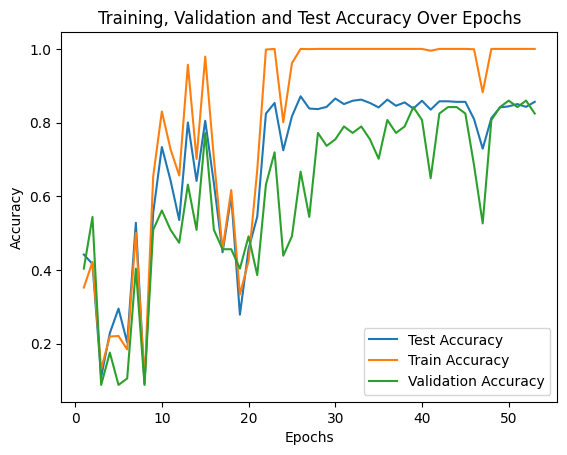

In [319]:
import matplotlib.pyplot as plt

# Creamos un rango de épocas (asumir que la longitud de test_acc y train_acc es igual)
epochs = range(1, len(test_acc) + 1)

# Creamos el gráfico
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Agregamos etiquetas y título al gráfico
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation and Test Accuracy Over Epochs')
plt.legend()
plt.show()


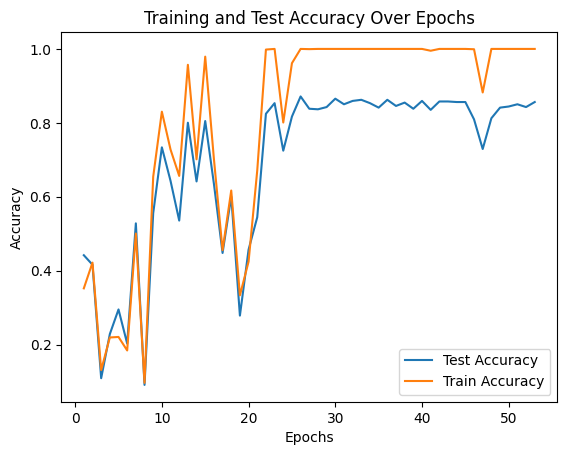

In [320]:
import matplotlib.pyplot as plt

# Creamos un rango de épocas (asumir que la longitud de test_acc y train_acc es igual)
epochs = range(1, len(test_acc) + 1)

# Creamos el gráfico
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.plot(epochs, train_acc, label='Train Accuracy')
#plt.plot(epochs, val_acc, label='Validation Accuracy')

# Agregamos etiquetas y título al gráfico
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

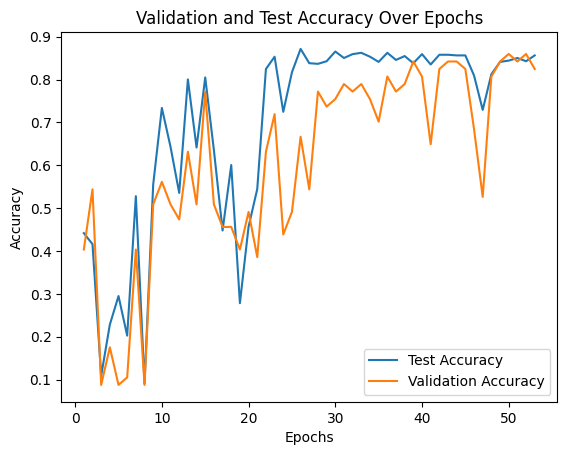

In [321]:
import matplotlib.pyplot as plt

# Creamos un rango de épocas (asumir que la longitud de test_acc y train_acc es igual)
epochs = range(1, len(test_acc) + 1)

# Creamos el gráfico
plt.plot(epochs, test_acc, label='Test Accuracy')
#plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Agregamos etiquetas y título al gráfico
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Test Accuracy Over Epochs')
plt.legend()
plt.show()

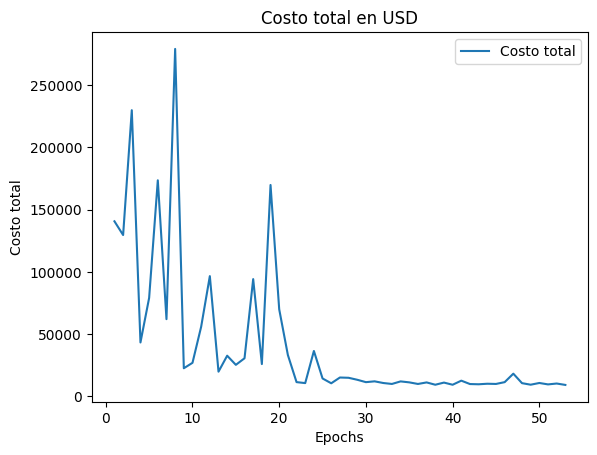

In [322]:
import matplotlib.pyplot as plt

# Creamos un rango de épocas (asumir que la longitud de test_acc y train_acc es igual)
epochs = range(1, len(costo_total_lista) + 1)

# Creamos el gráfico
plt.plot(epochs,costo_total_lista, label='Costo total')

# Agregamos etiquetas y título al gráfico
plt.xlabel('Epochs')
plt.ylabel('Costo total')
plt.title('Costo total en USD')
plt.legend()
plt.show()



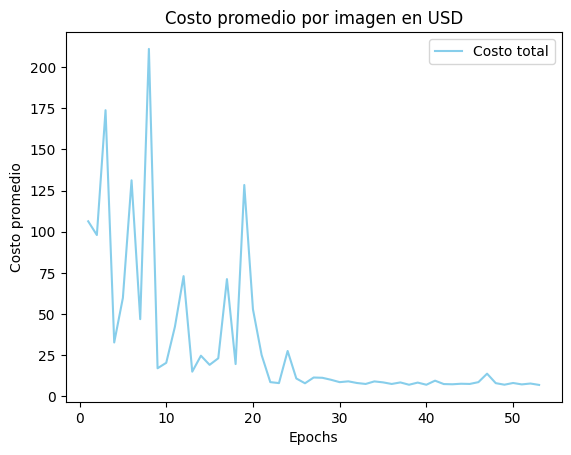

In [323]:
import matplotlib.pyplot as plt

# Creamos un rango de épocas (asumir que la longitud de test_acc y train_acc es igual)
epochs = range(1, len(costo_total_lista) + 1)

# Creamos el gráfico
plt.plot(epochs,costo_prom_lista, label='Costo total', color="skyblue")

# Agregamos etiquetas y título al gráfico
plt.xlabel('Epochs')
plt.ylabel('Costo promedio')
plt.title('Costo promedio por imagen en USD')
plt.legend()
plt.show()


In [324]:
data_resultados = {
    'epochs': epochs,
    'test_acc': test_acc,
    'val_acc': val_acc,
    'train_acc': train_acc,
    'costo_total_lista': costo_total_lista,
    'costo_prom_lista': costo_prom_lista
}

# Crear el DataFrame
df_results = pd.DataFrame(data_resultados)

In [325]:
df_results

,epochs,test_acc,val_acc,train_acc,costo_total_lista,costo_prom_lista
0,1,0.441755,0.403509,0.352104,140536,106.305598
1,2,0.416036,0.543860,0.421771,129512,97.966717
2,3,0.108926,0.087719,0.130914,229698,173.750378
3,4,0.228442,0.175439,0.219158,43298,32.751891
4,5,0.295008,0.087719,0.220610,79058,59.801815
5,6,0.202723,0.105263,0.184035,173438,131.193646
6,7,0.527988,0.403509,0.500435,62004,46.901664
7,8,0.090772,0.087719,0.096372,278870,210.945537
8,9,0.555219,0.508772,0.653991,22600,17.095310
9,10,0.733737,0.561404,0.830189,26968,20.399395


In [326]:
# Exportamos el dataframe


# Exportamos el DataFrame a un archivo Excel
df_results.to_excel('resultados_modelo.xlsx', index=False)

In [327]:
df_resultados.to_excel('resultados_modelo.xlsx', index=False)

In [328]:
from google.colab import files

# Descargamos el archivo desde Colab a tu máquina local
files.download('resultados_modelo.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [329]:
# Descargamos el modelo entrenado
torch.save(model.state_dict(), 'modelo_entrenado.pth')

# Descargar el modelo desde Colab a tu máquina local
files.download('modelo_entrenado.pth') #86.5% de accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Verificamos resultados

In [330]:
true_labels

array([0, 0, 0, ..., 2, 2, 2])

In [331]:
predicted_labels

array([0, 0, 0, ..., 2, 2, 4])

In [332]:
df_resultados

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,Costo unitario
0,0,4,0,74,44,30
1,0,4,0,74,44,30
2,0,4,0,74,44,30
3,0,4,0,74,44,30
4,0,4,0,74,44,30
...,...,...,...,...,...,...
1317,2,4,0,35,44,45
1318,2,4,0,35,44,45
1319,2,4,0,35,44,45
1320,2,4,0,35,44,45


In [333]:
# Exportamos el DataFrame a un archivo Excel
df_results.to_excel('resultados_predicted_true_modelo.xlsx', index=False)

In [334]:
# Descargamos el archivo desde Colab a tu máquina local
#files.download('resultados_predicted_true_modelo.xlsx')

In [335]:
df_resultados["perdida"] = costo_unitario

In [336]:
result_means = df_resultados.groupby("True Labels").mean()

In [337]:
result_means

,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,Costo unitario,perdida
True Labels,,,,,,
0,4.0,0.0,74.0,44.0,30.0,1.811594
1,4.0,0.0,109.0,44.0,65.0,2.215686
2,4.0,0.0,35.0,44.0,45.0,40.535714
3,4.0,0.0,89.0,44.0,45.0,4.472222
4,4.0,1.0,44.0,44.0,0.0,14.411765


In [338]:
df_resultados.groupby("True Labels").count()

,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,Costo unitario,perdida
True Labels,,,,,,
0,552,552,552,552,552,552
1,306,306,306,306,306,306
2,112,112,112,112,112,112
3,216,216,216,216,216,216
4,136,136,136,136,136,136


In [339]:
df_resultados.groupby("True Labels").count()

,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,Costo unitario,perdida
True Labels,,,,,,
0,552,552,552,552,552,552
1,306,306,306,306,306,306
2,112,112,112,112,112,112
3,216,216,216,216,216,216
4,136,136,136,136,136,136


In [340]:
# Agregamos la nueva columna 'Prediccion_Correcta' al DataFrame
df_resultados['Acierto en prediccion'] = (df_resultados['Precio_Verdadero'] == df_resultados['Precio_predicho']).astype(int)


In [341]:
# Establecer el modelo en modo de evaluación
model.eval()

# Lista para almacenar las etiquetas reales y predichas
true_labels = []
predicted_labels = []

# Realizar predicciones en el conjunto de prueba
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convertir las etiquetas a numpy arrays para facilitar la comparación
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

Testing: 100%|██████████| 42/42 [00:06<00:00,  6.65it/s]


In [342]:
df_resultados2 = pd.DataFrame({'True Labels': true_labels, 'Predicted Labels': predicted_labels})
df_resultados2['Correct Prediction'] = (df_resultados2['True Labels'] == df_resultados2['Predicted Labels']).astype(int)

In [343]:
df_resultados2

,True Labels,Predicted Labels,Correct Prediction
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1317,2,4,0
1318,2,2,1
1319,2,2,1
1320,2,2,1


In [344]:
df_resultados2['Precio_Verdadero'] = df_resultados2['True Labels'].apply(asignar_precio)
df_resultados2['Precio_predicho'] = df_resultados2['Predicted Labels'].apply(asignar_precio)

In [345]:
costo_unitario = [calculate_cost(df_resultados2['Precio_predicho'][i], df_resultados2['Precio_Verdadero'][i]) for i in range(len(df_resultados2))]

In [346]:
df_resultados2['costo unitario'] = costo_unitario

In [347]:
df_resultados2

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
0,0,0,1,74,74,0
1,0,0,1,74,74,0
2,0,0,1,74,74,0
3,0,0,1,74,74,0
4,0,0,1,74,74,0
...,...,...,...,...,...,...
1317,2,4,0,35,44,45
1318,2,2,1,35,35,0
1319,2,2,1,35,35,0
1320,2,2,1,35,35,0


In [348]:
df_resultados2.to_excel('resultados_modelo_test.xlsx', index=False)
# Descargamos el archivo desde Colab a tu máquina local
files.download('resultados_modelo_test.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [349]:
df_resultados2['Correct Prediction'].sum()

1132

In [350]:
df_resultados2['Correct Prediction'].sum()/len(df_resultados2['Correct Prediction'])

0.8562783661119516

In [351]:
1322 - 1144

178

In [352]:
df_resultados2['costo unitario'].sum()

9226

# Análisis accuracy por fruta en test

In [353]:
errores_pred = df_resultados2[df_resultados2['Correct Prediction'] == 0]

In [354]:
errores_pred

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
168,0,1,0,74,109,175
213,0,3,0,74,89,75
275,0,1,0,74,109,175
281,3,2,0,89,35,54
298,3,0,0,89,74,15
...,...,...,...,...,...,...
1309,2,4,0,35,44,45
1310,2,4,0,35,44,45
1316,2,4,0,35,44,45
1317,2,4,0,35,44,45


# Manzanas

In [355]:
errores_manzanas = errores_pred[errores_pred["True Labels"] == 0]

In [356]:
errores_manzanas

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
168,0,1,0,74,109,175
213,0,3,0,74,89,75
275,0,1,0,74,109,175
829,0,1,0,74,109,175
874,0,3,0,74,89,75
936,0,1,0,74,109,175


In [357]:
df_resultados2[df_resultados2['True Labels'] == 0]

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
0,0,0,1,74,74,0
1,0,0,1,74,74,0
2,0,0,1,74,74,0
3,0,0,1,74,74,0
4,0,0,1,74,74,0
...,...,...,...,...,...,...
932,0,0,1,74,74,0
933,0,0,1,74,74,0
934,0,0,1,74,74,0
935,0,0,1,74,74,0


In [388]:
porcentaje_error_manzanas = len(errores_manzanas["Correct Prediction"])/len(df_resultados2[df_resultados2['True Labels'] == 1]["Correct Prediction"])
porcentaje_error_manzanas

0.0196078431372549

In [389]:
1- porcentaje_error_manzanas

0.9803921568627451

In [390]:
label_counts_manzanas = errores_manzanas["Predicted Labels"].value_counts()
label_counts_manzanas

1    4
3    2
Name: Predicted Labels, dtype: int64

In [360]:
sum(errores_manzanas["costo unitario"])

850

# Melon

In [361]:
errores_melon = errores_pred[errores_pred["True Labels"] == 1]
errores_melon

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
459,1,2,0,109,35,74
462,1,0,0,109,74,35
477,1,0,0,109,74,35
503,1,0,0,109,74,35
521,1,3,0,109,89,20
527,1,0,0,109,74,35
530,1,0,0,109,74,35
584,1,0,0,109,74,35
1120,1,2,0,109,35,74
1123,1,0,0,109,74,35


In [362]:
df_resultados2[df_resultados2['True Labels'] == 1]

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
452,1,1,1,109,109,0
453,1,1,1,109,109,0
454,1,1,1,109,109,0
455,1,1,1,109,109,0
456,1,1,1,109,109,0
...,...,...,...,...,...,...
1261,1,1,1,109,109,0
1262,1,1,1,109,109,0
1263,1,1,1,109,109,0
1264,1,1,1,109,109,0


In [363]:
porcentaje_error_melon = len(errores_melon["Correct Prediction"])/len(df_resultados2[df_resultados2['True Labels'] == 1]["Correct Prediction"])

In [364]:
porcentaje_error_melon

0.05228758169934641

In [365]:
1 - porcentaje_error_melon

0.9477124183006536

In [366]:
label_counts_melon = errores_melon["Predicted Labels"].value_counts()
label_counts_melon

0    12
2     2
3     2
Name: Predicted Labels, dtype: int64

In [367]:
sum(errores_melon["costo unitario"])

608

# Naranjas

In [368]:
errores_naranjas = errores_pred[errores_pred["True Labels"] == 2]
errores_naranjas

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
606,2,3,0,35,89,270
608,2,4,0,35,44,45
609,2,4,0,35,44,45
618,2,1,0,35,109,370
619,2,4,0,35,44,45
624,2,4,0,35,44,45
625,2,4,0,35,44,45
626,2,3,0,35,89,270
627,2,4,0,35,44,45
629,2,4,0,35,44,45


In [369]:
label_counts_naranjas = errores_naranjas["Predicted Labels"].value_counts()

In [370]:
label_counts_naranjas

4    42
3     4
1     4
Name: Predicted Labels, dtype: int64

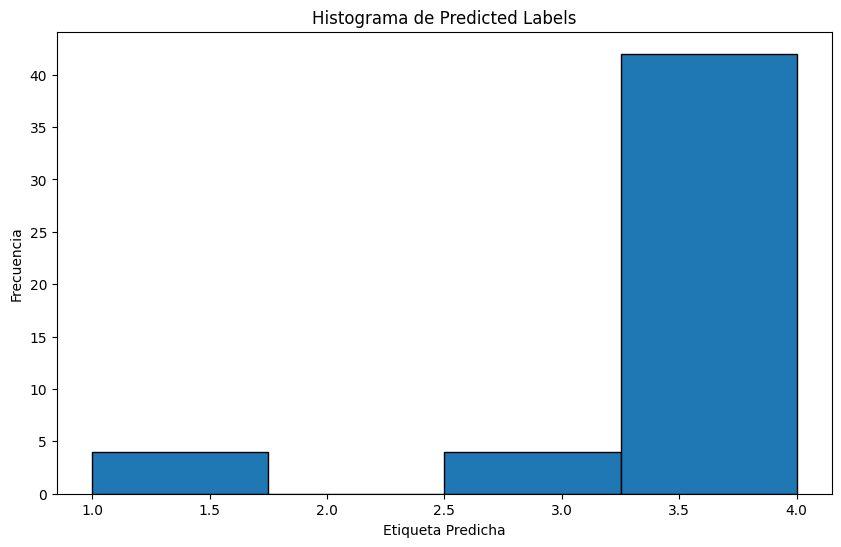

In [371]:
plt.figure(figsize=(10, 6))
plt.hist(errores_naranjas["Predicted Labels"], bins=4, edgecolor='black')

# Configurar el título y las etiquetas del eje
plt.title('Histograma de Predicted Labels')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [372]:
porcentaje_error_naranja = len(errores_naranjas["Correct Prediction"])/len(df_resultados2[df_resultados2['True Labels'] == 2]["Correct Prediction"])
porcentaje_error_naranja

0.44642857142857145

In [373]:
1 - porcentaje_error_naranja

0.5535714285714286

In [374]:
sum(errores_naranjas["costo unitario"])

4450

In [375]:
sum(errores_naranjas[errores_naranjas["Predicted Labels"] != 4]["costo unitario"])

2560

# Peras

In [376]:
errores_peras = errores_pred[errores_pred["True Labels"] == 3]
errores_peras

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
281,3,2,0,89,35,54
298,3,0,0,89,74,15
309,3,2,0,89,35,54
322,3,1,0,89,109,100
327,3,0,0,89,74,15
...,...,...,...,...,...,...
1037,3,0,0,89,74,15
1039,3,0,0,89,74,15
1040,3,0,0,89,74,15
1041,3,0,0,89,74,15


In [377]:
label_counts_peras = errores_peras["Predicted Labels"].value_counts()
label_counts_peras

0    58
2     4
1     2
Name: Predicted Labels, dtype: int64

In [378]:
porcentaje_error_peras = len(errores_peras["Correct Prediction"])/len(df_resultados2[df_resultados2['True Labels'] == 3]["Correct Prediction"])
porcentaje_error_peras

0.2962962962962963

In [379]:
1 - 0.25

0.75

In [380]:
sum(errores_peras["costo unitario"])

1286

In [381]:
sum(errores_peras[errores_peras["Predicted Labels"] != 0]["costo unitario"])

416

# Mandarinas

In [382]:
errores_mandarinas = errores_pred[errores_pred["True Labels"] == 4]
errores_mandarinas

,True Labels,Predicted Labels,Correct Prediction,Precio_Verdadero,Precio_predicho,costo unitario
385,4,2,0,44,35,9
392,4,2,0,44,35,9
393,4,1,0,44,109,325
395,4,2,0,44,35,9
398,4,2,0,44,35,9
399,4,2,0,44,35,9
400,4,2,0,44,35,9
401,4,2,0,44,35,9
404,4,0,0,44,74,150
407,4,2,0,44,35,9


In [383]:
porcentaje_error_mandarinas = len(errores_mandarinas["Correct Prediction"])/len(df_resultados2[df_resultados2['True Labels'] == 4]["Correct Prediction"])
porcentaje_error_mandarinas

0.39705882352941174

In [384]:
1 - porcentaje_error_mandarinas

0.6029411764705883

In [385]:
label_counts_mandarinas = errores_mandarinas["Predicted Labels"].value_counts()
label_counts_mandarinas

2    48
1     4
0     2
Name: Predicted Labels, dtype: int64

In [386]:
sum(errores_mandarinas["costo unitario"])

2032

In [387]:
sum(errores_mandarinas[errores_mandarinas["Predicted Labels"] != 2]["costo unitario"])

1600